# Normal Pneumonia Corona Chest X-ray Classification

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Activation, ZeroPadding2D, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#building the neural net
model = Sequential()
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', input_shape=(64,64,1), activation='relu'))
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.40))
model.add(Dense(3, activation='softmax'))

In [3]:
#variable for Image Generator to read from separate files 
gen = ImageDataGenerator()

In [4]:
#from files load shape, set color to grayscale, shuffle images for seed, batch size
train_batches = gen.flow_from_directory("chest_xray/train_all",model.input_shape[1:3],color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16)
valid_batches = gen.flow_from_directory("chest_xray/val", model.input_shape[1:3],color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=24)
test_batches = gen.flow_from_directory("chest_xray/test", model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=8)


Found 5533 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Found 669 images belonging to 3 classes.


In [5]:
#compile the model
model.compile(Adam(lr=0.001),loss="categorical_crossentropy", metrics=["accuracy"])

In [6]:
#class imbalance
#create weights for class imbalance
import numpy as np
COUNT_PNEUMONIA=3875
COUNT_NORMAL=1341
COUNT_CORONA=248
TRAIN_IMG_COUNT=COUNT_NORMAL+COUNT_PNEUMONIA+COUNT_NORMAL
#initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
#initial_bias
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
weight_for_2 = (1 / COUNT_CORONA)*(TRAIN_IMG_COUNT)/3.0

class_weight = {0: weight_for_0, 1: weight_for_1,2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 2.44
Weight for class 1: 0.85
Weight for class 2: 8.81


In [7]:
#fit the model
hist=model.fit(train_batches,validation_data=valid_batches,epochs=30, steps_per_epoch=16, validation_steps=1, class_weight=class_weight)

Epoch 1/30
16/16 [==============================] - 5s 294ms/step - loss: 3.1222 - accuracy: 0.5781 - val_loss: 4.5270 - val_accuracy: 0.5417
Epoch 2/30
16/16 [==============================] - 5s 296ms/step - loss: 1.8272 - accuracy: 0.6953 - val_loss: 7.4008 - val_accuracy: 0.3333
Epoch 3/30
16/16 [==============================] - 4s 264ms/step - loss: 0.7844 - accuracy: 0.8242 - val_loss: 2.0691 - val_accuracy: 0.5833
Epoch 4/30
16/16 [==============================] - 4s 268ms/step - loss: 0.9728 - accuracy: 0.7695 - val_loss: 0.5496 - val_accuracy: 0.7917
Epoch 5/30
16/16 [==============================] - 4s 277ms/step - loss: 0.4931 - accuracy: 0.8398 - val_loss: 3.4906 - val_accuracy: 0.6250
Epoch 6/30
16/16 [==============================] - 4s 254ms/step - loss: 0.7161 - accuracy: 0.8125 - val_loss: 1.3343 - val_accuracy: 0.6667
Epoch 7/30
16/16 [==============================] - 5s 292ms/step - loss: 0.8915 - accuracy: 0.8398 - val_loss: 0.8608 - val_accuracy: 0.7500
Epoch 

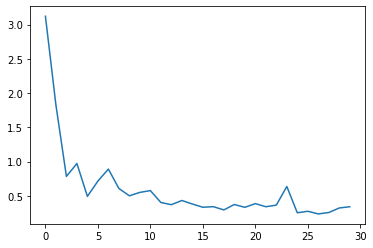

In [8]:
plt.plot(hist.history['loss'])


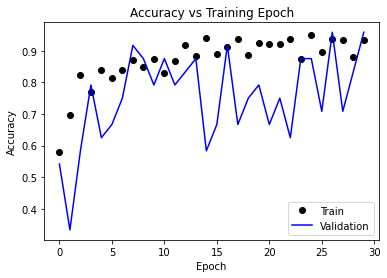

In [9]:
plt.plot(hist.history['accuracy'], 'ko')
plt.plot(hist.history['val_accuracy'], 'b')

plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation']);

In [10]:
#predict on the model
no_steps = len(test_batches)
p = model.predict(test_batches, steps=no_steps, verbose=True)
pre = pd.DataFrame(p)

84/84 [==============================] - 6s 73ms/step


In [11]:
pre

,0,1,2
0,1.907542e-02,1.240712e-02,0.968517
1,7.546164e-01,7.644037e-02,0.168943
2,1.131955e-02,1.747515e-02,0.971205
3,1.589842e-02,5.263315e-02,0.931468
4,2.791253e-01,2.192147e-02,0.698953
...,...,...,...
664,2.943599e-07,5.779128e-05,0.999942
665,1.016459e-08,1.644002e-11,1.000000
666,1.067291e-06,8.820100e-05,0.999911
667,4.630333e-06,9.559170e-05,0.999900


In [12]:
pre["filename"] = test_batches.filenames

In [14]:
#class prediction results
pred=[]
for index, row in pre.iterrows():
    #print(index, row[0])
    max_=pre.max(axis=1)[index]
    if row[0]==max_:
        pred.append(0)
    if row[1]==max_:
        pred.append(1)
    if row[2]==max_:
        pred.append(2)

In [15]:
len(pred)

669

In [16]:
#true class results
actuals=[]
for name in pre['filename']:
    if name[0]=='N':
        actuals.append(0)
    if name[0]=="P":
        actuals.append(1)
    if name[0]=='c':
        actuals.append(2)

In [17]:
pre['label']=actuals

In [18]:
pre['pred']=pred

In [19]:
len(actuals)

669

In [35]:
pre.head(60)

,0,1,2,filename,label,pred
0,0.019075,0.012407,0.968517,NORMAL/IM-0001-0001.jpeg,0,2
1,0.754616,0.076440,0.168943,NORMAL/IM-0003-0001.jpeg,0,0
2,0.011320,0.017475,0.971205,NORMAL/IM-0005-0001.jpeg,0,2
3,0.015898,0.052633,0.931468,NORMAL/IM-0006-0001.jpeg,0,2
4,0.279125,0.021921,0.698953,NORMAL/IM-0007-0001.jpeg,0,2
5,0.945404,0.033230,0.021365,NORMAL/IM-0009-0001.jpeg,0,0
6,0.225123,0.006700,0.768176,NORMAL/IM-0010-0001.jpeg,0,2
7,0.045109,0.011098,0.943793,NORMAL/IM-0011-0001-0001.jpeg,0,2
8,0.111525,0.011258,0.877217,NORMAL/IM-0011-0001-0002.jpeg,0,2
9,0.093846,0.003417,0.902737,NORMAL/IM-0011-0001.jpeg,0,2


In [21]:
accuracy_score(pre["label"], pre["pred"])

0.8011958146487295

In [23]:
from sklearn.metrics import recall_score
recall_score(pre["label"], pre["pred"], average=None)

array([0.54273504, 0.93333333, 1.        ])

In [25]:
from sklearn.metrics import f1_score
f1_score(pre["label"], pre["pred"], average=None)

array([0.66145833, 0.89765721, 0.62937063])

In [34]:
from sklearn.metrics import f1_score
f1_score(pre["label"], pre["pred"], average='weighted')

0.7969943819361234

In [27]:
pre.to_csv('PCNresults.csv')

In [28]:
zero=pre.loc[pre['label'] == 0]

In [30]:
zero['pred'].value_counts()

0    127
1     57
2     50
Name: pred, dtype: int64

In [31]:
one=pre.loc[pre['label'] == 1]

one['pred'].value_counts()

1    364
0     23
2      3
Name: pred, dtype: int64

In [33]:
two=pre.loc[pre['label'] == 2]
two['pred'].value_counts()

2    45
Name: pred, dtype: int64

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(pre['label'],pre['pred'])

array([[127,  57,  50],
       [ 23, 364,   3],
       [  0,   0,  45]])

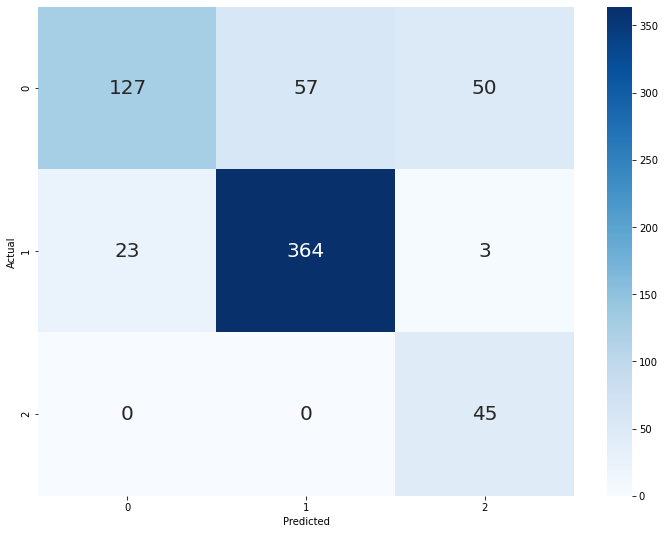

In [46]:
#confusion matrix
import seaborn as sn
confusion_matrix = pd.crosstab(pre['label'],pre['pred'], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(12, 9))
sn.heatmap(confusion_matrix, annot=True, cmap="Blues", annot_kws={"fontsize":20}, fmt='g')
plt.show()